In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import analyze_toolbox as toolbox

import ipywidgets as widgets
from IPython.display import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data = toolbox.load_data(dropna=True, scale_id=0.2)
data["rgyr_ratio"] = ( data["rgyr"]  / data["rgyr"].head(1).values - 1 )*100.

sample_data = pd.Series([], dtype='float64');
for parameter in data.index:
    if ("rmsf" not in parameter) and ("nc" not in parameter):   
        sample_data[ parameter] = toolbox.sample(data, parameter, delta=500, skip_initial=4, scale_id=0.2)
    elif ("nc" in parameter):
        sample_data[ parameter] = toolbox.sample(data, parameter, delta=50 , skip_initial=4, scale_id=0.2)

# Plot cartain trajetory for given type

Text(0, 0.5, 'enc')

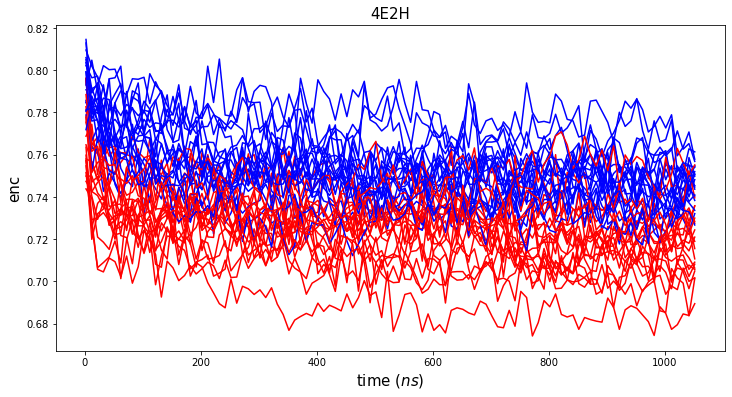

In [3]:
parameter = "enc"

fig = plt.figure(figsize=(12,6))
toolbox.plot_type_trj(data[parameter], '4E2H', stepsize=5, threshold=0)
plt.ylabel(parameter, fontsize=15)

# ACF to find decorrelation length (to be corrected...)

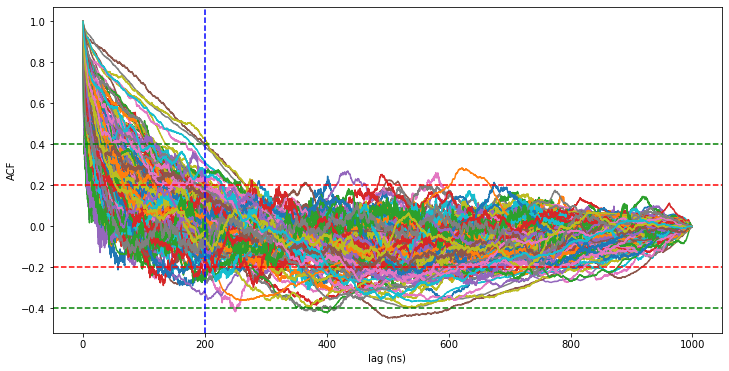

In [4]:
fig = plt.figure(figsize=(12,6))
for column in data["rgyr"].columns:
    r = toolbox.ACF(data["rgyr"][column].values[:5000], exclude_steps=4)
    plt.plot(0.2*np.arange(0,len(r),1), r)

plt.xlabel("lag (ns)")
plt.ylabel("ACF")
plt.axhline(y= 0.4, color='g', ls='--')
plt.axhline(y=-0.4, color='g', ls='--')
plt.axhline(y= 0.2, color='r', ls='--')
plt.axhline(y=-0.2, color='r', ls='--')
plt.axvline(x= 200, color='b', ls='--')

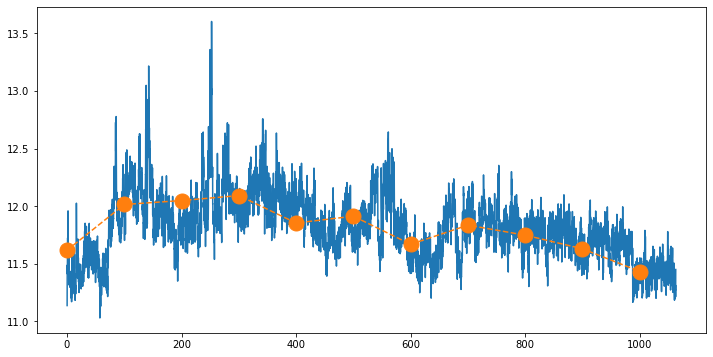

In [5]:
fig = plt.figure(figsize=(12,6))

parameter = 'rgyr'
ptype='r_1_3E2H_b_1'
data[parameter][ptype].plot()
plt.plot(sample_data[parameter][ptype].index, sample_data[parameter][ptype], ls='--', marker='o', markersize=15)

# Plot the trjectories plus historgram

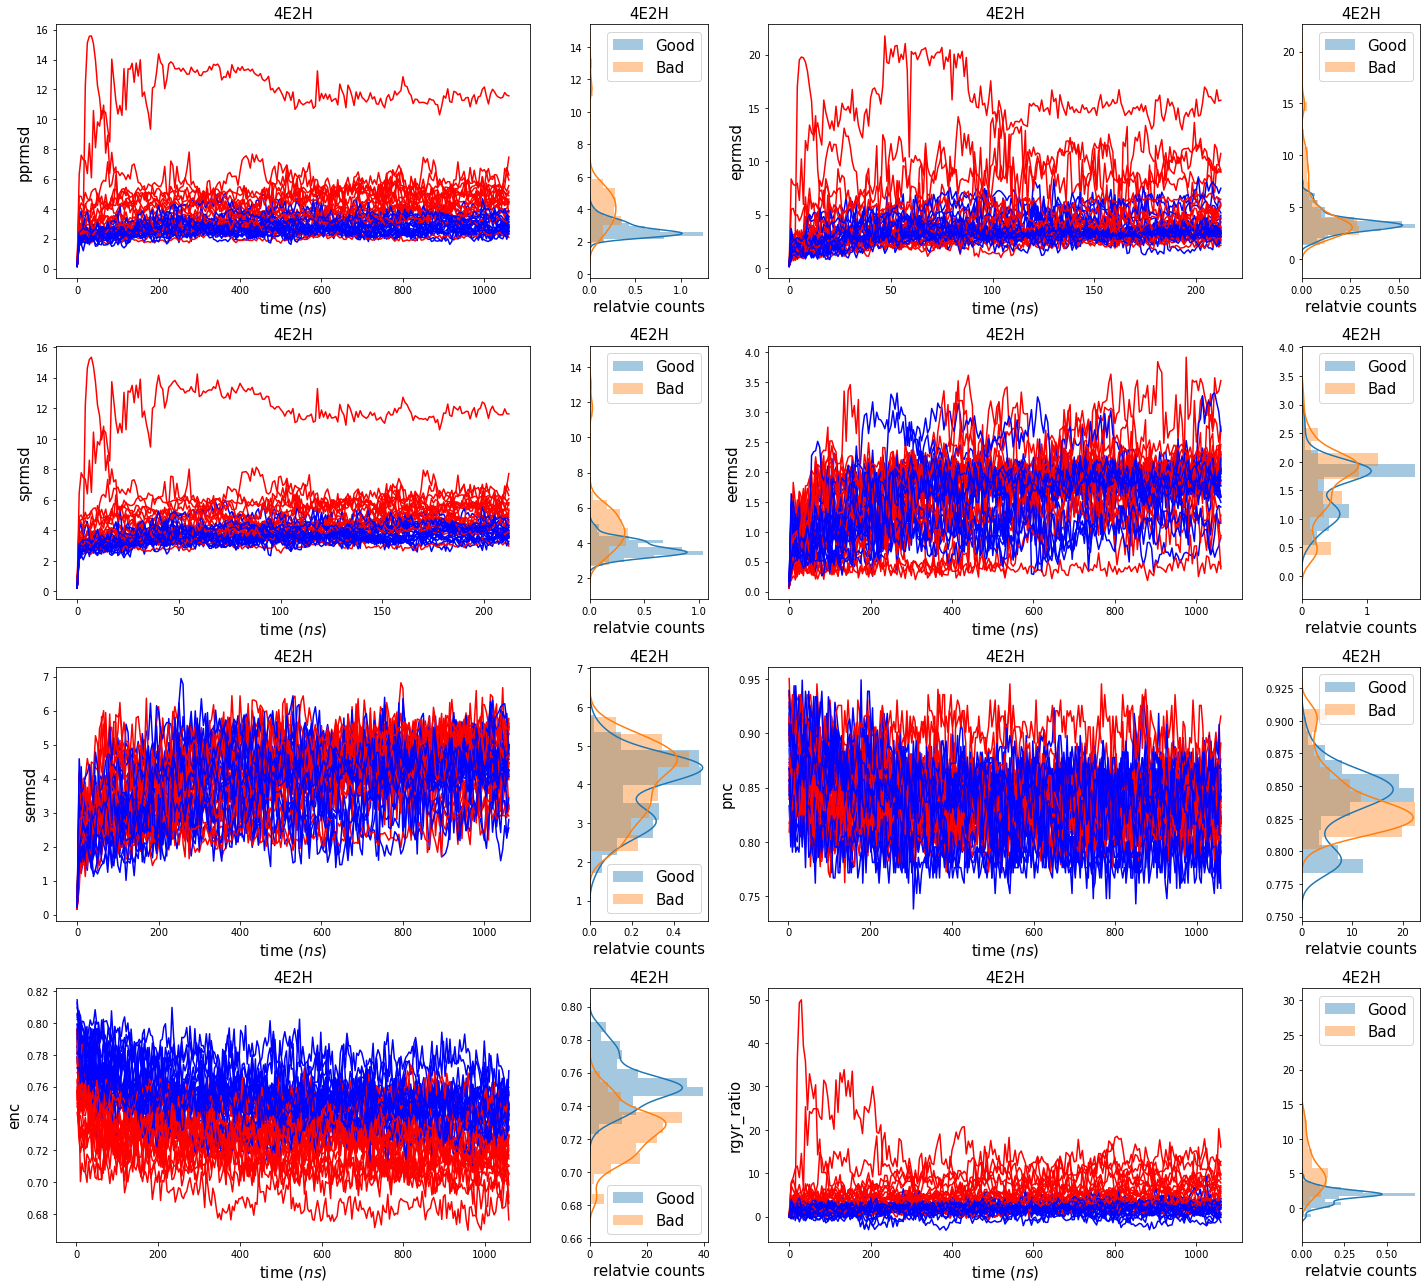

In [6]:
# should i normalize the before plot the histogram?
toolbox.plot_all_parameter(data, sample_data, "4E2H")

# Plot PCA analysis of rmsf

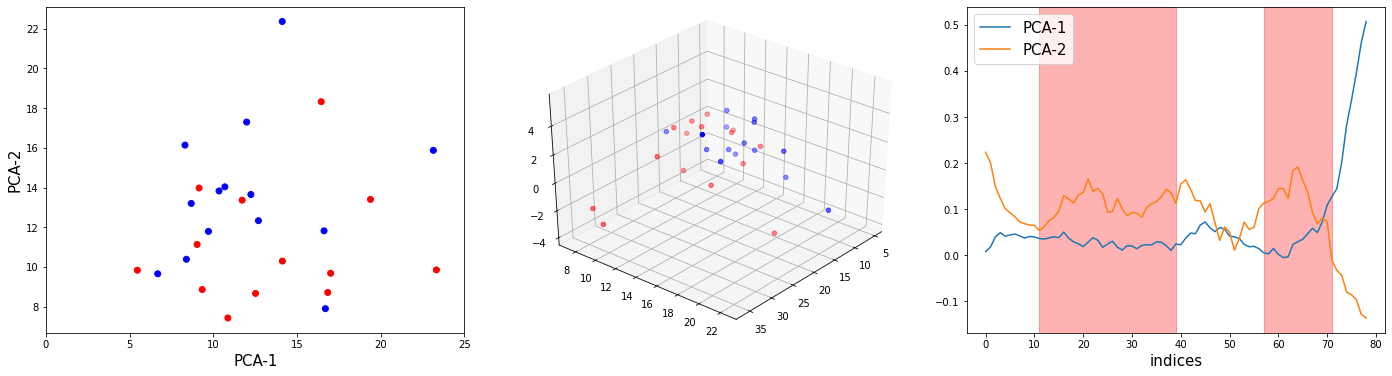

In [7]:
ptype = "4H"
toolbox.pca_rmsf(ptype, data["rmsf"], clip_from_start=0, clip_from_tail=0)
#plt.savefig(ptype+'.jpg')

# Plot PCA analysis through time

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

sample_points = toolbox.get_sample_points(data, sample_data)
pca.fit(pd.concat((sample_points["g"],sample_points["b"])))

proj_good = np.dot(sample_points["g"], pca.components_.T)
proj_bad  = np.dot(sample_points["b"] , pca.components_.T)

def pca_projection(phi, theta):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(phi, theta)
    ax.scatter3D(proj_good[:,0], proj_good[:,1], proj_good[:,2], c='b')
    ax.scatter3D(proj_bad[:,0], proj_bad[:,1], proj_bad[:,2], c='r')

In [9]:
plot_controls = widgets.interactive(pca_projection,
                                    phi=widgets.IntSlider(min=-90, max=90, step=5, value=40, description="$\Phi$"),
                                    theta=widgets.IntSlider(min=0, max=360, step=5, value=220, description="$\Theta$"),
)
display(plot_controls)

interactive(children=(IntSlider(value=40, description='$\\Phi$', max=90, min=-90, step=5), IntSlider(value=220…

# SVM for prediction

In [125]:
from sklearn.utils import shuffle
from sklearn.svm import SVC

n_points = len(sample_points["b"])
label = pd.Series( np.concatenate([np.zeros(n_points), np.ones(n_points)] ), name="label")
sample_points["all"] = pd.concat( [sample_points["b"], sample_points["g"]], axis=0 )
sample_points["all"].index = np.arange(2*n_points)
sample_points["all"] = pd.concat( [sample_points["all"], label], axis=1 )

sample_points["shuffle"] = shuffle(sample_points["all"])

In [126]:
train_set   = sample_points["shuffle"].drop("label", 1).values[:1000]
train_label = sample_points["shuffle"]["label"].values[:1000]
test_set   = sample_points["shuffle"].drop("label", 1).values[1000:]
test_label = sample_points["shuffle"]["label"].values[1000:]

In [133]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(train_set, train_label)
y_pred = svclassifier.predict(test_set)

acc = np.where(y_pred==test_label,1,0)
print("test accuracy: ", np.sum(acc)/len(acc))

test accuracy:  0.8722222222222222
